In [10]:
# Dependencies
import tweepy
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import os

import time

plt.style.use('fivethirtyeight')

In [2]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


consumer_key = os.getenv("bot_consumer_key")
consumer_secret = os.getenv("bot_consumer_secret")
access_token = os.getenv("bot_access_token")
access_token_secret = os.getenv("bot_access_token_secret")


In [3]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [4]:
def parse_requests(tweet, tweet_dict=dict()):
    tweet_data = []
    tweet_id = tweet["id"]
    tweet_user = tweet["user"]["screen_name"]
    tweet_requests = []
    print(tweet_id)
    for mentions in tweet["entities"]["user_mentions"]:
        if mentions["screen_name"] != "PySentiBot":
            tweet_requests.append(mentions["screen_name"])
    
    tweet_dict = {"id":tweet_id,"user":tweet_user,"analysis_requests":tweet_requests}
    return tweet_dict

In [5]:
def analyze_sentiments(recent_tweets, sentiment_results=list()):
    sentiment_results = []
    for tweet in recent_tweets:
        new_tweet = cleanse_tweet(tweet)
        sentiment_result = analyzer.polarity_scores(new_tweet["text"])
        sentiment_results.append(sentiment_result)    
    return sentiment_results

In [6]:
def remove_noise(tweet, category, key, result_tweet=dict()):
    try:
        result_tweet = tweet
        tweet_text = tweet.get("text")
        tweet_items = tweet.get("entities").get(category)
        for item in tweet_items:
            replace_str = item[key]
            tweet_text = tweet_text.replace(replace_str," ")
        result_tweet["text"] = tweet_text
    except TypeError:
        pass
    return result_tweet

def cleanse_tweet(tweet,result_tweet=dict()):
    result_tweet = tweet
    result_tweet = remove_noise(result_tweet,"user_mentions","screen_name")
    result_tweet = remove_noise(result_tweet,"urls","url")
    result_tweet = remove_noise(result_tweet,"media","url")
    result_tweet["text"] = result_tweet["text"].replace("@","")
    return result_tweet

In [7]:
def color_map(value):
    if(value >= 0): 
        return 'g'
    else:
        return 'r'

def plot_sentiments(title,sentiments):
    df = pd.DataFrame(sentiments)
    df = df.reset_index()
#     df.plot(kind="scatter",x="index",y="compound",marker="o")
    df.plot( 'index', 'compound', linestyle='-', marker='o',alpha=0.75)
    plt.ylabel("Sentiment score")
    plt.xlabel("Tweets")
    plt.title(title)
    
    filename = "SentimentAnalysis_of_"+title+".png"
    plt.savefig(filename)
    
    return filename  

In [8]:
def scan_for_requests(since_tweet_id):
    search_handle = "@PySentiBot"

    results = api.search(search_handle,since_id = since_tweet_id)

    if(len(results["statuses"]) > 0):
        tweet_data = []

        for tweet in results["statuses"]:
            tweet_data.append(parse_requests(tweet))
        
        for item in tweet_data:

            recent_tweets = []

            for analyze_request in item["analysis_requests"]:

                recent_tweets = api.user_timeline(analyze_request,count=200)

                if(len(recent_tweets) > 0):
                    sentiments = analyze_sentiments(recent_tweets)
                    print(sentiments)
                    sentiment_fig = plot_sentiments(analyze_request,sentiments)
                    text_status = f"{datetime.now} - Thank you for your tweet @{item['user']}! Here is the sentiment analysis of {analyze_request}!"
                    api.update_with_media(filename=sentiment_fig,status=text_status,in_reply_to_status_id=item["id"])
                else:
                    text_status = f"{datetime.now} - Thank you for your tweet @{item['user']}! Sorry, {analyze_request} has no tweets!" 
                    api.update_status(text_status)

                plt.show()
        return results["statuses"][0]["id"]
    else:
        return since_tweet_id

935137061757218816
935132891889233920
934868262533451779
933930946721648641
[{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'compound': 0.7096}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 0.863, 'pos': 0.137, 'compound': 0.4019}, {'neg': 0.0, 'neu': 0.863, 'pos': 0.137, 'compound': 0.4019}, {'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.4767}, {'neg': 0.158, 'neu': 0.724, 'pos': 0.118, 'compound': -0.2263}, {'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'compound': 0.1655}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}, {'neg': 0.143, 'neu': 0.69, 'pos': 0.167, 'compound': 0.128}, {'neg': 0.125, 'neu': 0.714, 'pos': 0.161, 'compound': 0.1027}, {'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.7184}, {'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'compound': 0.4019}, {'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.6908}, {'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'compound': -0.128}, {'neg'

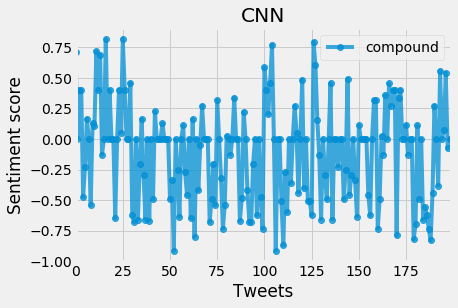

[{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'compound': 0.481}, {'neg': 0.235, 'neu': 0.765, 'pos': 0.0, 'compound': -0.6486}, {'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'compound': 0.2263}, {'neg': 0.125, 'neu': 0.724, 'pos': 0.151, 'compound': 0.1027}, {'neg': 0.0, 'neu': 0.676, 'pos': 0.324, 'compound': 0.34}, {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.4588}, {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.6369}, {'neg': 0.252, 'neu': 0.491, 'pos': 0.258, 'compound': 0.0258}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.3612}, {'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'compound': 0.4767}, {'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.4215}, {'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.7579}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.296, 'neu': 0.704, 'pos': 0.0, 'compound': -0.5849}, {'neg': 0.0, 'neu': 0.724, 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\ssank\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-1e1d73b96afe>", line 3, in <module>
    since_tweet_id = scan_for_requests(since_tweet_id)
  File "<ipython-input-8-64aae8a6e238>", line 25, in scan_for_requests
    api.update_with_media(filename=sentiment_fig,status=text_status,in_reply_to_status_id=item["id"])
  File "C:\Users\ssank\Anaconda3\envs\py36\lib\site-packages\tweepy\api.py", line 232, in update_with_media
    )(*args, **kwargs)
  File "C:\Users\ssank\Anaconda3\envs\py36\lib\site-packages\tweepy\binder.py", line 245, in _call
    return method.execute()
  File "C:\Users\ssank\Anaconda3\envs\py36\lib\site-packages\tweepy\binder.py", line 217, in execute
    self.api.last_response = resp
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent

KeyboardInterrupt: 

In [9]:
since_tweet_id = 933930057860599809
while True:
    since_tweet_id = scan_for_requests(since_tweet_id)
    time.sleep(300)